In [2]:
%pip install pymorphy2
%pip install python-Levenshtein
!pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [100]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pymorphy2
import Levenshtein
import gensim.downloader

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Чтение данных

In [101]:
data = pd.read_csv("Data\paronym.csv", index_col=0)

Препроцессинг

In [102]:
# installing model
word2vec_rus = gensim.downloader.load('word2vec-ruscorpora-300')

In [103]:
morph = pymorphy2.MorphAnalyzer()

# get a part of speech needed to make an embedding of word
def get_part_of_speech(word):
    
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS

    if pos == "ADJF":
        return "ADJ"
    if pos == "INFN":
        return "VERB"
    
    return pos 

In [104]:
# making embedding by pretrained word2vec model 
def get_embedding(word):

    w2v_word = f"{word}_{get_part_of_speech(word)}"

    try:
        emb = word2vec_rus[w2v_word]

    except KeyError:
        return None
    
    return emb

In [105]:
# add extra columns for embeddings 
for i in range(600):
    data[f"emb_{int(i > 299) + 1}_{i % 300}"] = 0
# add extra columns for Levenshtein distance
data["lev_dist"] = 0

rows_to_drop = []

# add embeddings to dataframe 
for i in range(len(data)):

    # get embs for two words
    word1 = data.word1[i]
    word2 = data.word2[i]
    emb1 = get_embedding(word1)
    emb2 = get_embedding(word2)

    if emb1 is not None and emb2 is not None:
        # add embeddings
        data.loc[i, "emb_1_0":"emb_1_299"] = emb1
        data.loc[i, "emb_2_0":"emb_2_299"] = emb2
        data.loc[i, "lev_dist"] = Levenshtein.distance(word1, word2)
        print("YES", data.word1[i], data.word2[i])

    else: 
        # delete words that are not in word2vec vocabulary
        rows_to_drop.append(i)
        print("NO", data.word1[i], data.word2[i])

data = data.drop(rows_to_drop, axis=0).reset_index(drop=True)
data.head()

YES аккордовый квадрат
YES целый цельный
YES женский господний
YES обличительный динамизм
NO сыскать снискать
NO начертать начертить
YES фактичный ординарный
YES личностный личный
NO чеканный чеканочный
YES методистский антипедагогический
NO хлеборобный хлеборобский
NO гневливый обезденежеть
NO героизм дудочный
YES знамя глинистый
YES игристый игривый
YES демократический чиновничий
NO светить светлить
YES автоматичный автоматический
YES цикличный циклический
NO накрапывать накрапливать
YES статичный артистический
NO надувательский надувательный
YES земляной земной
NO рогастый собственный
NO хвостистый избирательский
NO безголосный морозный
YES мистичный зимовник
YES двойственный двоякий
NO желтеть насильственно
NO полированный цепенить
YES возраст рост
YES диктат горловина
YES опытный сыскать
YES глубинный глубокий
YES неврастенический неврастеничный
YES могущественный могучий
YES трубчатый трубочный
YES конъюнктура соседский
YES швейцар швейцарец
YES героический геройский
YES монистич

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,8
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,2
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,7
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,12
4,фактичный,ординарный,0,0.032032,-0.006285,-0.047780,0.033934,-0.016947,0.057922,-0.048563,...,-0.053290,-0.077826,-0.116725,-0.032819,-0.008684,-0.138111,0.051320,-0.003383,-0.044410,7


PCA сокращение размерности эмбедингов

In [106]:
# fitting PCA
def fit_pca(X, n):
    pca = PCA(n_components=n)
    pca.fit(X)
    return pca

# transform dataset to n_componets dimansion
def reduce_dimension(pca, X):
    X_transformed = pca.transform(X)
    return X_transformed

In [107]:
X = data.drop(["word1", "word2", "label"], axis=1)
y = data["label"]

pca_n_components = 50

# fit PCA
pca = fit_pca(pd.concat([X.loc[:, "emb_1_0":"emb_1_299"], X.loc[:, "emb_2_0":"emb_2_299"].rename(columns={f"emb_2_{i}":f"emb_1_{i}" for i in range(300)}) ], ignore_index=True), pca_n_components)

# reduce dimensuon with PCA
X.loc[:, "emb_1_0":f"emb_1_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_1_0":"emb_1_299"])
X.loc[:, f"emb_2_0":f"emb_2_{pca_n_components-1}"] = reduce_dimension(pca, X.loc[:, "emb_2_0":"emb_2_299"])

# drop extra columns of embedding
X = X.drop(list(X.columns[pca_n_components:300]) + list(X.columns[300+pca_n_components:-1]), axis=1)
X.head()

,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,emb_1_7,emb_1_8,emb_1_9,...,emb_2_41,emb_2_42,emb_2_43,emb_2_44,emb_2_45,emb_2_46,emb_2_47,emb_2_48,emb_2_49,lev_dist
0,0.308833,0.007849,-0.246683,0.051231,0.072148,-0.117797,0.112604,-0.180261,0.007842,0.010445,...,-0.051056,-0.010534,-0.054085,-0.046142,-0.089680,0.035116,0.059190,-0.007180,0.039732,8
1,-0.076505,0.072699,0.019286,-0.045792,0.120196,-0.045043,-0.017430,-0.076066,-0.066431,-0.068982,...,0.110001,-0.054922,-0.098695,-0.005667,0.084724,0.087734,0.128344,-0.002422,0.086304,2
2,-0.073320,-0.040571,-0.029276,0.097177,0.105689,-0.070894,-0.052849,-0.017578,-0.102903,0.185368,...,-0.054236,-0.008637,0.019965,-0.048863,-0.107497,0.049397,-0.033663,0.044982,-0.006791,7
3,0.095996,-0.331475,0.021940,0.081845,0.093367,-0.061097,0.052816,-0.265499,0.023706,0.075224,...,-0.070321,0.066404,-0.065225,0.136811,0.003958,-0.008308,-0.058051,-0.063684,0.064833,12
4,0.302057,-0.269803,-0.093604,-0.111010,0.038898,-0.195118,-0.040643,0.043945,-0.051710,-0.040503,...,-0.065991,0.108684,-0.015937,0.052412,-0.019896,0.091908,0.026538,0.022021,-0.028762,7


In [108]:
# PCA explained variance 
np.sum(pca.explained_variance_ratio_)

0.47525934464662717

Катбуст

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)

predictions = cat_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('MAE:', mae)

MAE: 0.04666666666666667


In [110]:
# get feature importance
feature_importances = cat_model.feature_importances_

for i, importance in enumerate(feature_importances):
    print(f"{X.columns[i]}: {importance}")

emb_1_0: 3.551325576562124
emb_1_1: 3.1916593960110755
emb_1_2: 0.30562315800196105
emb_1_3: 0.7020864154074921
emb_1_4: 0.4711297020137421
emb_1_5: 0.6217076400726886
emb_1_6: 0.3445883914541959
emb_1_7: 0.7979118416002294
emb_1_8: 0.8492191701721761
emb_1_9: 0.8390010598750258
emb_1_10: 1.2179212868189941
emb_1_11: 0.13079093848015083
emb_1_12: 0.3412260586135067
emb_1_13: 0.23055163337872508
emb_1_14: 0.2633511163846177
emb_1_15: 0.7035102916558165
emb_1_16: 0.2532086936893369
emb_1_17: 0.23257077011505206
emb_1_18: 0.28679283097838515
emb_1_19: 0.47653597773691925
emb_1_20: 0.21090017335179984
emb_1_21: 0.49276581024375643
emb_1_22: 0.34184342273385965
emb_1_23: 0.372293748724517
emb_1_24: 0.48427562839223
emb_1_25: 0.2738358577212389
emb_1_26: 0.20169003428487084
emb_1_27: 0.23890829313667258
emb_1_28: 0.45189500233484003
emb_1_29: 0.26813800448972325
emb_1_30: 0.1542824651539162
emb_1_31: 0.15101416217271812
emb_1_32: 0.1656331261992858
emb_1_33: 0.13469428671155992
emb_1_34: 0.6

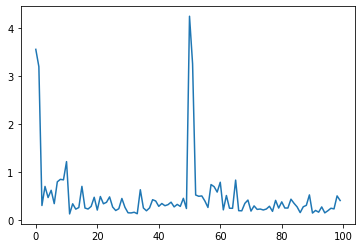

In [111]:
# plotting feature importance of embeddings
plt.plot(cat_model.feature_importances_[:-1])

Нейросеть

15/15 [==============================] - 0s 1ms/step
MAE: 0.05979402021401458


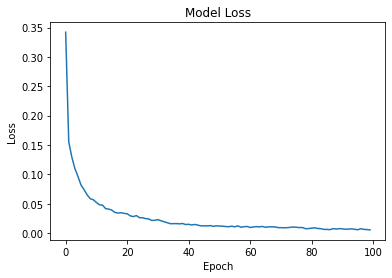

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(96, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', loss='mean_absolute_error')

history = nn_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)

predictions = nn_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('MAE:', mae)

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Тестирование

In [113]:
# function for testing new words
def test(word1, word2, model):

    # getting embs and lev dist 
    emb1, emb2 = get_embedding(word1), get_embedding(word2)
    pca_emb1 = reduce_dimension(pca, emb1.reshape(1, -1))
    pca_emb2 = reduce_dimension(pca, emb2.reshape(1, -1))
    lev_dist = Levenshtein.distance(word1, word2)

    # creating dataframe
    row = pca_emb1.tolist()[0] + pca_emb2.tolist()[0] + [lev_dist]
    X_new = pd.DataFrame([row], columns=X.columns)
    
    # predictions 
    if model == "cat":
        prediction = cat_model.predict_proba(X_new)
        res = np.argmax(prediction[0])
        proba = max(prediction[0])

    if model == "nn":
        prediction = nn_model.predict(X_new)
        if prediction[0][0] < 0.5:
            res = 0
            proba = 1 - (prediction[0][0] if prediction[0][0] > 0 else 0)
        else:
            res = 1
            proba = (prediction[0][0] if prediction[0][0] < 1 else 1)

    # result
    print(f"Слова {word1} и {word2} {'не '*(not res)}являются паронимами с вероятностью {proba}")

In [114]:
# не паронимы
word1 = "приветливый"
word2 = "страна" 

# паронимы
word1 = "целый"
word2 = "цельный" 

# модель 
model = "cat" # nn - keras nn, cat - catboostclassifier

# тестирование
test(word1, word2, model)

Слова целый и цельный являются паронимами с вероятностью 0.9933629164158191


ДОП

In [97]:
data

,word1,word2,label,emb_1_0,emb_1_1,emb_1_2,emb_1_3,emb_1_4,emb_1_5,emb_1_6,...,emb_2_291,emb_2_292,emb_2_293,emb_2_294,emb_2_295,emb_2_296,emb_2_297,emb_2_298,emb_2_299,lev_dist
0,аккордовый,квадрат,0,-0.012578,0.071381,-0.066920,0.132629,0.039623,0.068954,-0.102715,...,0.012084,0.054774,0.012667,-0.049291,0.144537,-0.074161,-0.035057,0.081322,0.129544,0
1,целый,цельный,1,-0.019124,0.034811,0.057754,0.119841,-0.034180,0.042868,0.015424,...,0.032209,0.014659,0.024586,-0.071244,-0.106860,0.002109,0.057067,-0.029967,0.069121,0
2,женский,господний,0,0.044881,-0.092671,0.050879,-0.044229,0.011045,0.028815,-0.058337,...,0.073815,0.014237,0.103689,0.109344,0.009336,0.047421,0.005184,0.071654,-0.028561,0
3,обличительный,динамизм,0,0.066741,0.038244,0.027620,0.058278,0.048305,0.110592,-0.115581,...,-0.102109,0.129003,-0.052745,-0.043174,-0.039006,0.050456,-0.007910,-0.029959,0.016620,0
4,сыскать,снискать,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,гнилой,гнилостный,1,0.022569,-0.047862,0.049707,0.058395,0.006504,0.046971,0.035626,...,-0.091607,0.088824,0.001456,-0.006952,0.041889,0.050071,0.102235,-0.003491,-0.002087,0
3512,кормильщица,притягательный,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3513,абонемент,абонент,1,0.068919,0.042074,-0.030451,-0.087799,0.016597,-0.016370,0.019723,...,0.067424,0.100960,0.029388,-0.060928,0.016881,-0.025644,-0.061658,-0.017059,-0.043113,0
3514,беженец,выучить,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [96]:
get_embedding(data['word1'][0])

array([-1.25777004e-02,  7.13808015e-02, -6.69195578e-02,  1.32629201e-01,
        3.96230109e-02,  6.89538270e-02, -1.02715276e-01, -2.07985435e-02,
       -4.17454605e-04, -6.66920096e-02,  1.85652584e-01, -1.44832075e-01,
        2.83512380e-02, -1.11901104e-01,  4.56056818e-02, -4.81510274e-02,
        8.36276039e-02, -9.19803232e-03,  9.81500838e-04,  5.74996658e-02,
       -2.92572589e-03,  6.52177706e-02, -4.75657806e-02,  4.61040102e-02,
       -3.82861830e-02,  5.70593216e-02, -3.37926932e-02,  1.21076353e-01,
       -1.81092322e-02,  9.62400343e-03, -1.48299234e-02,  1.01952113e-01,
        1.60059571e-01, -5.47798118e-03,  3.87733914e-02,  3.83970179e-02,
        1.25514701e-01, -8.64881873e-02,  2.29348727e-02, -2.13215649e-02,
       -1.91617105e-02, -1.42319629e-03, -1.11882702e-01, -8.07544217e-02,
       -5.52563854e-02,  1.29661132e-02, -3.10040861e-02, -4.55451086e-02,
        4.72736470e-02, -7.49781057e-02, -9.20100696e-03,  5.29071130e-02,
        6.45692181e-03,  

In [85]:
morph = pymorphy2.MorphAnalyzer()

word = 'знамя_NOUN'
parsed_word = morph.parse(word)[0]
pos = parsed_word.tag.POS

print(pos)

None


In [ ]:


# Создаем набор данных
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

# Создаем объект PCA и указываем, что хотим снизить размерность до 2
pca = PCA(n_components=2)

# Обучаем PCA на наборе данных
pca.fit(X)

# Применяем PCA для снижения размерности
X_transformed = pca.transform(X)

# Выводим преобразованный набор данных
print(X_transformed)